In [1]:
import sys, os
import glob
import weakref

import matplotlib
from matplotlib.collections import PolyCollection
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import scipy

from bio2byte.mdutils.utils.BBanalysis import BBDihedrals, stack_uneven, boltzmann_energy

# --- Font size and familiy
matplotlib.rcParams['font.size']          =   10
matplotlib.rcParams['axes.labelsize']     =   10
matplotlib.rcParams['axes.linewidth']     =   1
matplotlib.rcParams['lines.linewidth']    =   .9
matplotlib.rcParams["mathtext.fontset"]   =    "dejavusans" # "dejavusans" "dejavuserif" "stix"
matplotlib.rcParams['axes.linewidth']     =   1
matplotlib.rcParams['lines.linewidth']    =   .9

def polygon_under_graph(x, y):
    """
    Construct the vertex list which defines the polygon filling the space under
    the (x, y) line graph. This assumes x is in ascending order.
    """
    return [(x[0], 0.), *zip(x, y), (x[-1], 0.)]

%matplotlib inline

In [2]:
residues = [
    "ALA", "ARG", "ASN", "ASP", "ASH",
    "CYS", "GLN", "GLU", "GLH", "GLY",
    "HIS", "HIP", "ILE", "LEU", "LYS",
    "MET", "PHE", "PRO", "SER", "S1P",
    "SEP", "THR", "T1P", "TPO", "TRP",
    "TYR", "Y1P", "PTR", "VAL"]

peptides = {}
for xx1 in residues:
    peptides[f"gg{xx1}gggGLYgg"] = BBDihedrals(f"../9peptides/gg{xx1}gggGLYgg/analy/dihedrals.csv")
    peptides[f"ggGLYggg{xx1}gg"] = BBDihedrals(f"../9peptides/ggGLYggg{xx1}gg/analy/dihedrals.csv")

peptide_names = [n for n in peptides.keys()]
print(peptide_names)

for bbobj in peptides.values():
    bbobj.histogram_bins = np.arange(-180,181,9)

['ggALAgggGLYgg', 'ggGLYgggALAgg', 'ggARGgggGLYgg', 'ggGLYgggARGgg', 'ggASNgggGLYgg', 'ggGLYgggASNgg', 'ggASPgggGLYgg', 'ggGLYgggASPgg', 'ggASHgggGLYgg', 'ggGLYgggASHgg', 'ggCYSgggGLYgg', 'ggGLYgggCYSgg', 'ggGLNgggGLYgg', 'ggGLYgggGLNgg', 'ggGLUgggGLYgg', 'ggGLYgggGLUgg', 'ggGLHgggGLYgg', 'ggGLYgggGLHgg', 'ggGLYgggGLYgg', 'ggHISgggGLYgg', 'ggGLYgggHISgg', 'ggHIPgggGLYgg', 'ggGLYgggHIPgg', 'ggILEgggGLYgg', 'ggGLYgggILEgg', 'ggLEUgggGLYgg', 'ggGLYgggLEUgg', 'ggLYSgggGLYgg', 'ggGLYgggLYSgg', 'ggMETgggGLYgg', 'ggGLYgggMETgg', 'ggPHEgggGLYgg', 'ggGLYgggPHEgg', 'ggPROgggGLYgg', 'ggGLYgggPROgg', 'ggSERgggGLYgg', 'ggGLYgggSERgg', 'ggS1PgggGLYgg', 'ggGLYgggS1Pgg', 'ggSEPgggGLYgg', 'ggGLYgggSEPgg', 'ggTHRgggGLYgg', 'ggGLYgggTHRgg', 'ggT1PgggGLYgg', 'ggGLYgggT1Pgg', 'ggTPOgggGLYgg', 'ggGLYgggTPOgg', 'ggTRPgggGLYgg', 'ggGLYgggTRPgg', 'ggTYRgggGLYgg', 'ggGLYgggTYRgg', 'ggY1PgggGLYgg', 'ggGLYgggY1Pgg', 'ggPTRgggGLYgg', 'ggGLYgggPTRgg', 'ggVALgggGLYgg', 'ggGLYgggVALgg']


# Residue effect propagation

## Overview

In [3]:
bbobjG = peptides["ggGLYgggGLYgg"]

rmsd = np.zeros((len(residues), 9))
for i,xx1 in enumerate(residues):
    bbobjX = peptides[f"ggGLYggg{xx1}gg"]
    for j,resi in enumerate(sorted(bbobjX.iterresids())):
        rmsd[i,j] = np.sum( (bbobjX.hist[resi] - bbobjG.hist[resi])**2 )
rmsdHead = np.sqrt(rmsd)

rmsd = np.zeros((len(residues), 9))
for i,xx1 in enumerate(residues):
    bbobjX = peptides[f"gg{xx1}gggGLYgg"]
    for j,resi in enumerate(sorted(bbobjX.iterresids())):
        rmsd[i,j] = np.sum( (bbobjX.hist[resi] - bbobjG.hist[resi])**2 )
rmsdTail = np.sqrt(rmsd)

In [4]:
rms = np.full((2*len(residues),13), np.nan)
for i, res in enumerate(residues):
    rms[2*i,4:] = rmsdTail[i]
    rms[2*i+1,:9] = rmsdHead[i]
rms[:,6] = 0

norm = matplotlib.colors.Normalize(vmin=0, vmax=np.nanmax(rms))

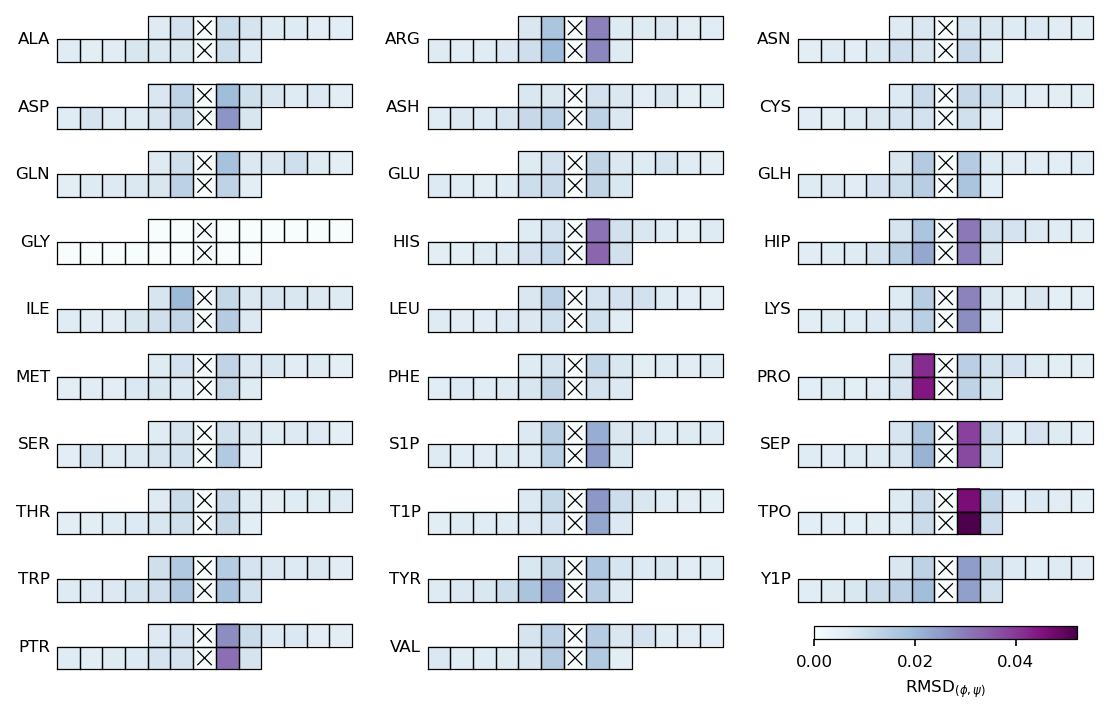

In [5]:
new_params = {
    "axes.labelsize": 8,
    "axes.linewidth": .6,
    'font.size': 8,
    'lines.linewidth': .6,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
}

bak_params = {k: matplotlib.rcParams[k] for k in new_params.keys()}
matplotlib.rcParams.update(new_params)


def plt_grid(ax, grid, extent):
    l,r,b,t = extent
    dx, dy = (r - l) / grid.shape[1], (t - b) / grid.shape[0]
    for i,y in enumerate(np.arange(b, t, dy)):
        for j,x in enumerate(np.arange(l, r, dx)):
            if not np.isnan(grid[~i,j]):
                ax.plot([x, x+dx, x+dx, x, x], [y, y, y+dy, y+dy, y], color="k")

fig, axs = plt.subplots(10,3, figsize=(7,4.5), dpi=150, 
                        gridspec_kw=dict(left=0., right=1., bottom=0., top=1., hspace=0))
    
for i, ax in enumerate(axs.flatten()):
    
    ax.set_axis_off()
    if i >= 29:
        cbar = plt.colorbar(im, ax=ax, fraction=.8, shrink=.85, orientation="horizontal")
        cbar.set_label("RMSD$_{(\phi, \psi)}$")
        continue
        
    im = ax.imshow(rms[2*i:2*i+2], cmap=cm.BuPu, norm=norm, extent=(-6.5,6.5,0,2))
    plt_grid(ax, rms[2*i:2*i+2], extent=(-6.5,6.5,0,2))

    ax.plot([-.3, .3, np.nan, -.3, .3], [1.2, 1.8, np.nan, 1.8, 1.2], color="k")
    ax.plot([-.3, .3, np.nan, -.3, .3], [.2, .8, np.nan,.8, .2], color="k")
        
    ax.set_xticks(np.arange(-6.5, 6.6, 1.), minor=True)
    ax.set_yticks([1])
    ax.set_yticklabels([res])
    ax.text(0.,.5, residues[i], transform=ax.transAxes, ha="right", va="center")
    ax.set_ylim([-.1, 2.1])
    ax.set_xlim([-6.8, 6.8])   
    
fig.savefig("figures/effect_propagation_by_residue.png", dpi=150, bbox_inches="tight")    

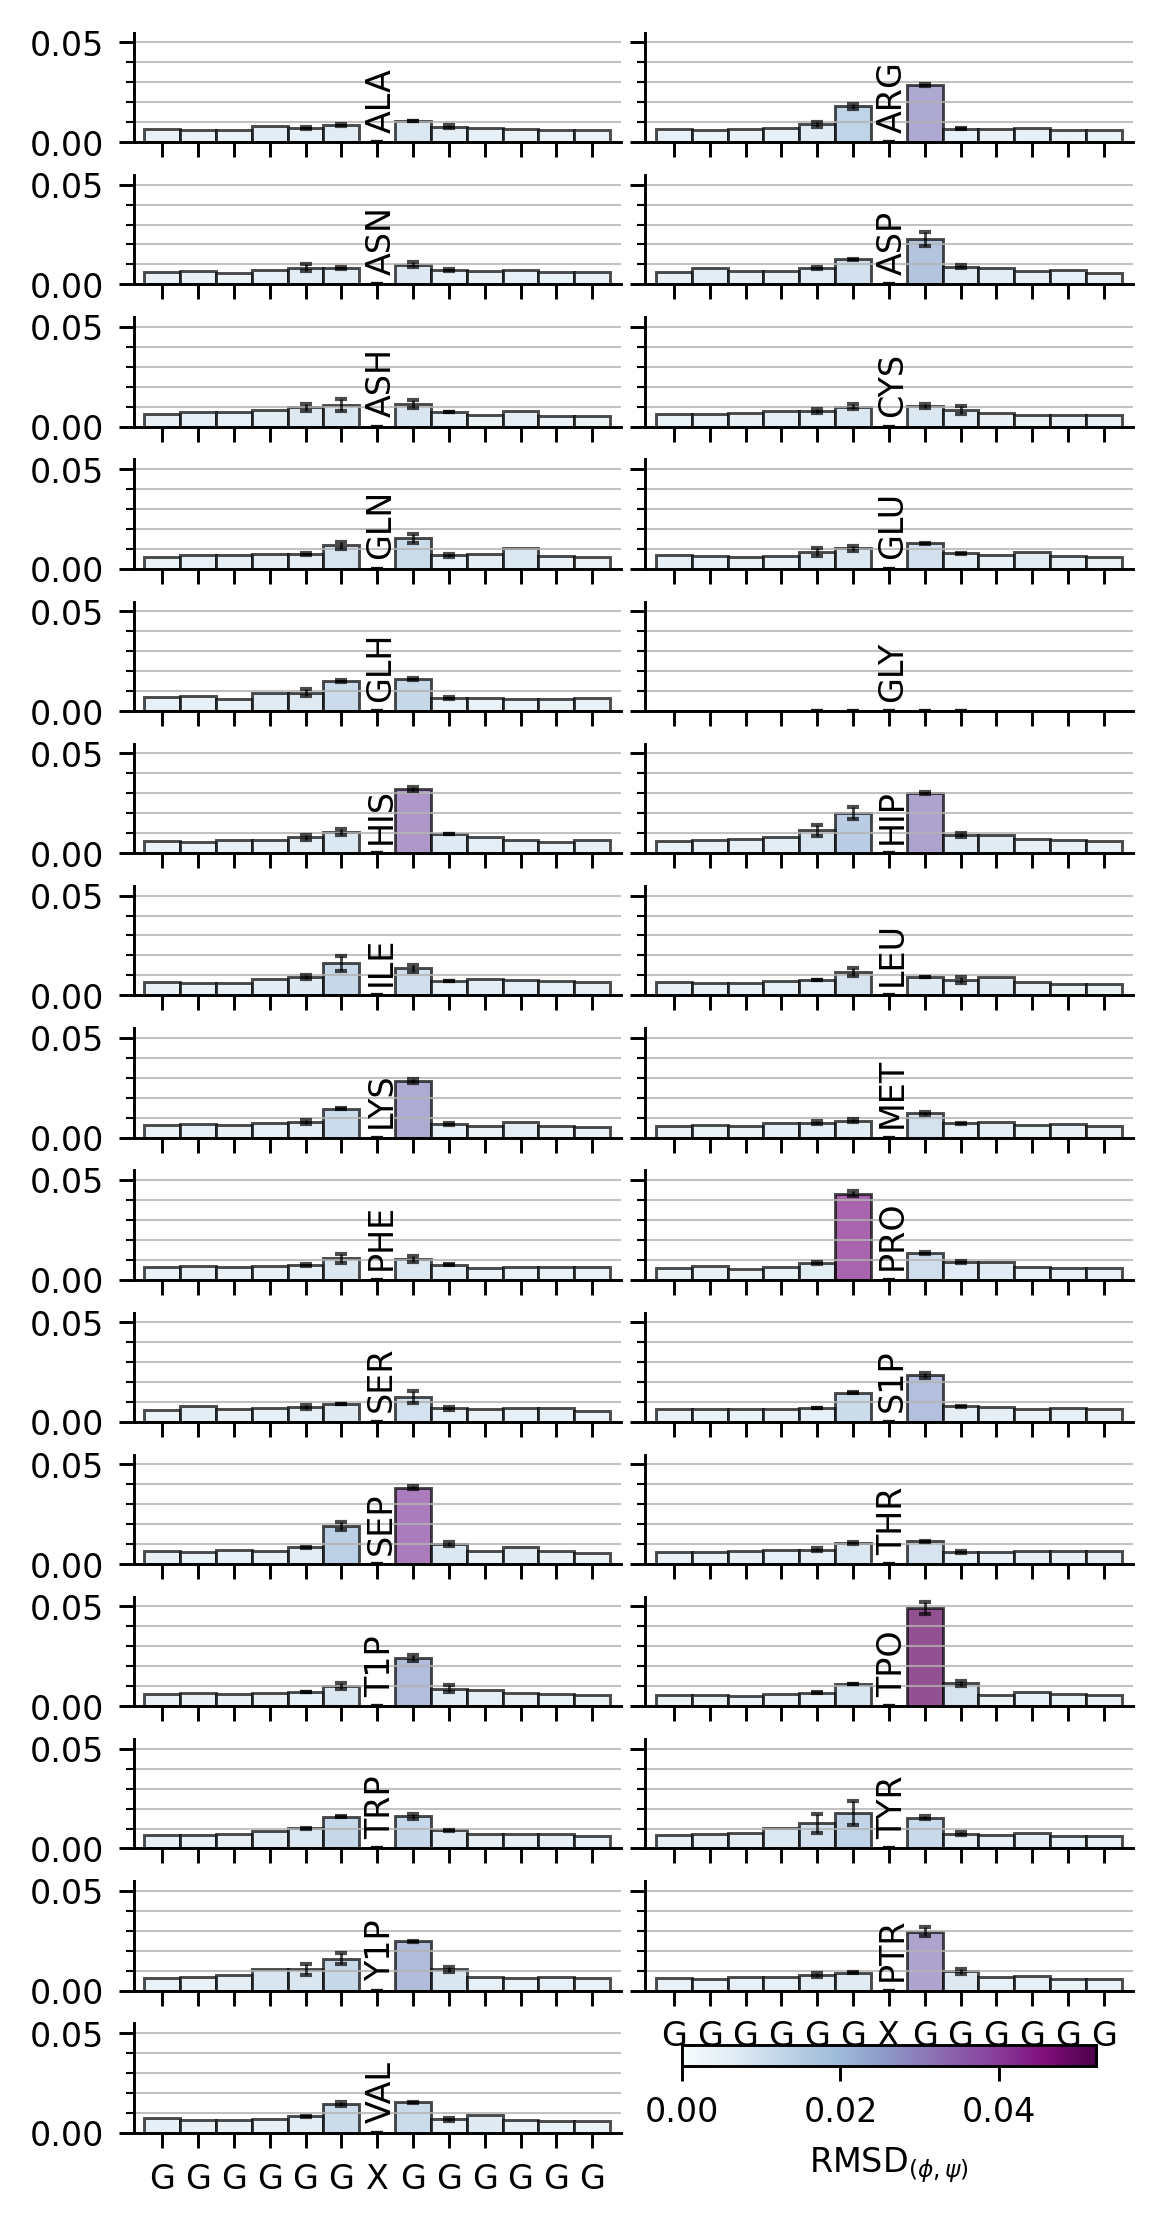

In [ ]:
new_params = {
    "axes.labelsize": 8,
    "axes.linewidth": .7,
    'boxplot.flierprops.linewidth': 2.0,
    'font.size': 8,
    "grid.linewidth": .5,
    'lines.linewidth': .7,
    "patch.linewidth": .7,
    'xtick.labelsize': 8,
    "xtick.major.width": .7,
    "xtick.minor.width": .5,
    'ytick.labelsize': 8,
    "ytick.major.width": .7,
    "ytick.minor.width": .5,
}
bak_params = {k: matplotlib.rcParams[k] for k in new_params.keys()}
matplotlib.rcParams.update(new_params)



fig, axs = plt.subplots(15,2, figsize=(3.33, 7), dpi=300, sharey=True,
                        gridspec_kw=dict(left=0., right=1., bottom=0., top=1., hspace=.3, wspace=.05))

for i, ax in enumerate(axs.flatten()):
    if i >= 29:
        ax.set_axis_off()
        cbar = plt.colorbar(im, ax=ax, fraction=.8, shrink=.85, orientation="horizontal")
        cbar.set_label("RMSD$_{(\phi, \psi)}$")
        continue
    ax.grid(True, "both", "y", color="0.7", alpha=.8, zorder=1)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
        
    height = np.nanmean(rms[2*i:2*i+2], axis=0)
    minmax = np.stack([np.min(rms[2*i:2*i+2], axis=0), np.max(rms[2*i:2*i+2], axis=0)])
    ax.bar(np.arange(-6,7,1), height, width=1, color=cm.BuPu(norm(height)),
           edgecolor="k", alpha=.7)
    ax.errorbar(np.arange(-6,7,1), height, yerr=np.abs(minmax - height),
                linestyle="none", color="k", capsize=1.5, alpha=.7)

    ax.text(.1,.005, residues[i], ha="center", va="bottom", rotation=90)
    
    ax.set_xticks(np.arange(-6,7,1))
    ax.set_xlim([-6.8, 6.8])
    ax.set_xticklabels([])
    if i >= 27:
        ax.set_xticklabels(["G" if x != 0 else "X" for x in range(-6, 7)])
        
ax.set_yticks(np.arange(0, .05, .01), minor=True)



fig.savefig("figures/effect_propagation_by_residue2.pdf", dpi=150, bbox_inches="tight")

matplotlib.rcParams.update(bak_params)

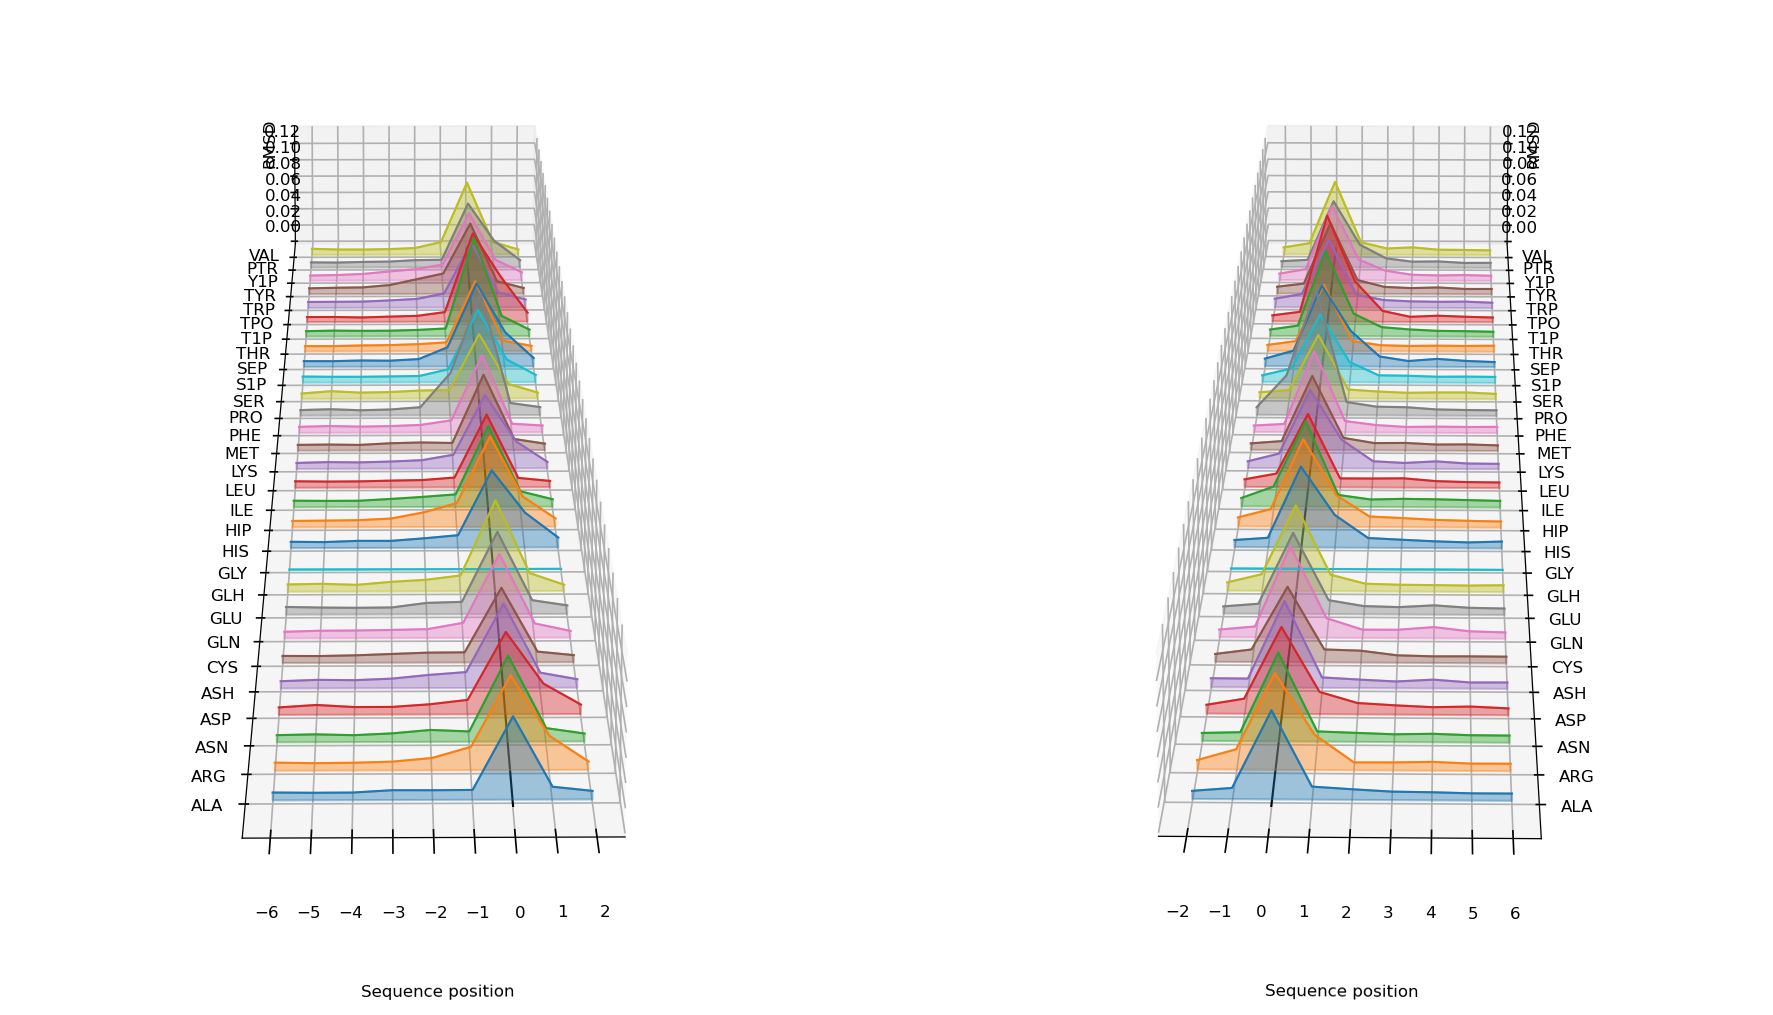

In [27]:
fig = plt.figure(figsize=(15,10), dpi=150)

ax = fig.add_subplot(1,2,1, projection="3d", proj_type = 'persp')
ax.set_box_aspect((2,14,1))

verts = []
colos = []
for i,resn in enumerate(residues):
    
    c = cm.tab10.colors[i%10]
    ax.plot(np.arange(-6,3), rmsdHead[i,:], i, zdir='y', linewidth=1,
            zorder=30-i, color=c, alpha=1, label=resn) 
    
    verts.append(polygon_under_graph(np.arange(-6,3), rmsdHead[i,:]))
    colos.append(c)
    
ax.plot([0,0], [-.5,len(residues)-.5], zs=0, linewidth=1, color="k")
poly = PolyCollection(verts, color=colos, alpha=.4)
ax.add_collection3d(poly, zs=np.arange(len(residues)), zdir="y")

ax.set_xlim([-6.5,2.5])
ax.set_xlabel("Sequence position")
ax.set_yticks(np.arange(len(residues)))
ax.set_ylim([-.5, len(residues)-.5])
ax.set_yticklabels(residues, ha="right", va="bottom")
ax.set_ylabel("")
ax.set_zlabel("RMSD", rotation=90)
ax.set_zlim([0,.138])
ax.azim, ax.dist, ax.elev = -90.5, 3.9, 14.9





ax = fig.add_subplot(1,2,2, projection="3d", proj_type = 'persp')
ax.set_box_aspect((2,14,1))

verts = []
colos = []
for i,resn in enumerate(residues):
    
    c = cm.tab10.colors[i%10]
    ax.plot(np.arange(-2,7), rmsdTail[i,:], i, zdir='y', linewidth=1,
            zorder=30-i, color=c, alpha=1, label=resn) 
    
    verts.append(polygon_under_graph(np.arange(-2,7), rmsdTail[i,:]))
    colos.append(c)
    
ax.plot([0,0], [-.5,len(residues)-.5], zs=0, linewidth=1, color="k")
poly = PolyCollection(verts, color=colos, alpha=.4)
ax.add_collection3d(poly, zs=np.arange(len(residues)), zdir="y")

ax.set_xlim([-2.5,6.5])
ax.set_xlabel("Sequence position")
ax.set_yticks(np.arange(len(residues)))
ax.set_ylim([-.5, len(residues)-.5])
ax.set_yticklabels(residues, ha="left", va="bottom")
ax.set_ylabel("")
ax.set_zlabel("RMSD", rotation=90)
ax.set_zlim([0,.138])
ax.azim, ax.dist, ax.elev = -89, 3.9, 14.9


#fig.savefig("peptide_propagation.pdf", format="pdf", dpi=600, bbox_inches="tight")

## Effects: Heading

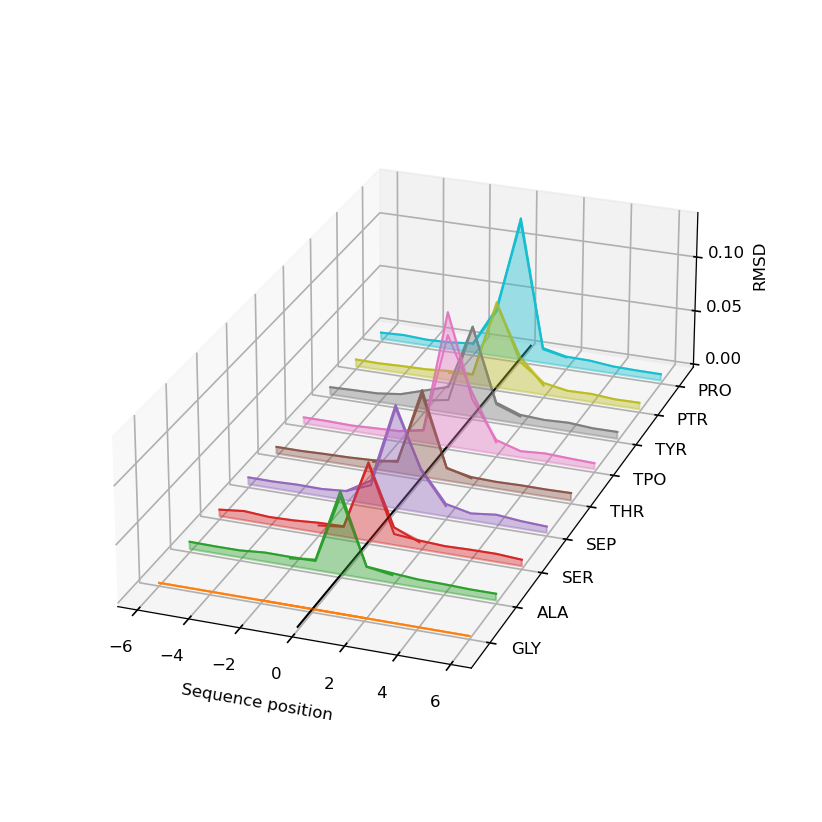

In [23]:
fig = plt.figure(figsize=(7,7), dpi=150)

ax = fig.add_subplot(1,1,1, projection="3d", proj_type = 'persp')
ax.set_box_aspect((2,4,1))

verts, colos, labels = [], [], []
for y, resn in enumerate(["GLY", "ALA", "SER", "SEP", "THR", "TPO", "TYR", "PTR", "PRO"][::-1]):
    labels.append(resn)
    c = cm.tab10.colors[y%10]
    ix = residues.index(resn)
    
    # Plot lines
    ax.plot(np.arange(-6,3), rmsdHead[ix,:], -y, zdir='y', linewidth=1,
            zorder=30-i, color=c, alpha=1, label=resn)
    ax.plot(np.arange(-2,7), rmsdTail[ix,:], -y, zdir='y', linewidth=1,
            zorder=30-i, color=c, alpha=1, label=resn) 
    
    # Build transparent polygon
    vertices = np.nanmax(np.stack([
        np.pad(rmsdHead[ix,:], (0,4), constant_values=np.nan),
        np.pad(rmsdTail[ix,:], (4,0), constant_values=np.nan)], axis=0), axis=0)
    verts.append(polygon_under_graph(np.arange(-6,7), vertices))
    colos.append(c)
    
ax.plot([0,0], [.5, -y-.5], zs=0, linewidth=1, color="k")
poly = PolyCollection(verts, color=colos, alpha=.4)
ax.add_collection3d(poly, zs=np.arange(0, -y-1, -1), zdir="y")
ax.set_xlim([-6.5,6.5])
ax.set_xlabel("Sequence position")
ax.set_yticks(np.arange(0, -y-1, -1))
ax.set_ylim([-y-.5, .5,])
ax.set_yticklabels(labels, ha="left", va="bottom")
ax.set_ylabel("")
ax.set_zlabel("RMSD", rotation=90)
ax.set_zticks(np.arange(0, .15, .05))
ax.set_zlim([0,.138])
ax.azim, ax.dist, ax.elev = (-70, 10, 25)

fig.savefig("peptide_tailing.pdf", format="pdf", dpi=600, bbox_inches="tight")

## Effects: heading

In [21]:
rmsd = np.zeros((len(peptides), 9))

bbobjG = peptides["ggGLYgggGLYgg"]
for i,xx1 in enumerate(residues):
    bbobjX = peptides[f"ggGLYggg{xx1}gg"]
    for j,resi in enumerate(sorted(bbobjX.iterresids())):
        rmsd[i,j] = np.sum( (bbobjX.hist[resi] - bbobjG.hist[resi])**2 )
rmsd = np.sqrt(rmsd)

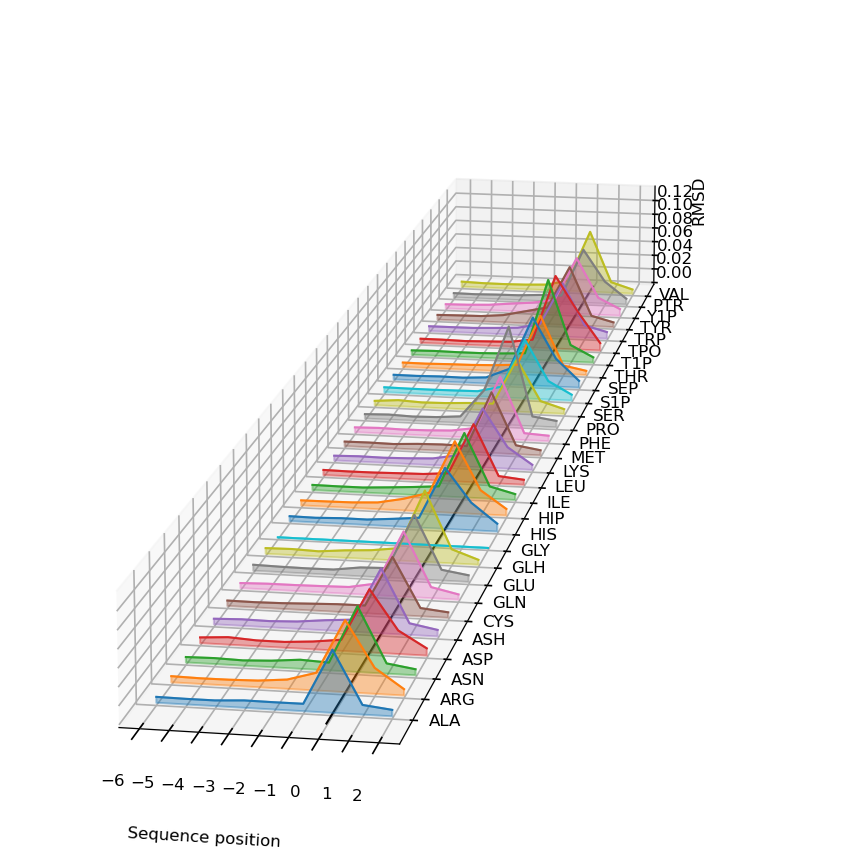

In [25]:
fig = plt.figure(figsize=(7,10), dpi=150)

ax = plt.axes(projection="3d")
ax.set_box_aspect((2,14,1))
ax.set_facecolor("w")

verts = []
colos = []
for i,resn in enumerate(residues):
    
    c = c = cm.tab10.colors[i%10]
    
    ax.plot(np.arange(-6,3), rmsd[i,:], i, zdir='y', linewidth=1,
            zorder=30-i, color=c, alpha=1, label=resn) 
    
    verts.append(polygon_under_graph(np.arange(-6,3), rmsd[i,:]))
    colos.append(c)
    
ax.plot([0,0], [-.5,len(residues)-.5], zs=0, linewidth=1, color="k")
poly = PolyCollection(verts, color=colos, alpha=.4)
ax.add_collection3d(poly, zs=np.arange(len(residues)), zdir="y")

ax.set_xlim([-6.5,2.5])
ax.set_xlabel("Sequence position")
ax.set_yticks(np.arange(len(residues)))
ax.set_ylim([-.5, len(residues)-.5])
ax.set_yticklabels(residues, ha="left", va="bottom")
ax.set_ylabel("")
ax.set_zlabel("RMSD", rotation=90)
ax.set_zlim([0,.138])
ax.azim, ax.dist, ax.elev = -80, 5, 15

#ax.legend(bbox_to_anchor=(0, .8))
#fig.savefig("peptide_heading.pdf", format="pdf", dpi=600, bbox_inches="tight")